# Polarized Image and Instrumental Modeling

## 환경 설정 

In [1]:
using Pkg
Pkg.activate("/home/bread/astro/Comrade.jl/examples/StokesIImaging")
Pkg.instantiate()

  Activating project at `~/astro/Comrade.jl/examples/StokesIImaging`
    Updating registry at `~/.julia/registries/General.toml`
   Installed Measurements ─ v2.11.0
    Updating `~/astro/Comrade.jl/examples/StokesIImaging/Project.toml`
  [13f3f980] + CairoMakie v0.11.8
  [99d987ce] + Comrade v0.9.2
  [a4336a5c] + ComradeAHMC v0.4.0
  [26988f03] + ComradeOptimization v0.1.5
  [31c24e10] + Distributions v0.25.107
  [ced4e74d] + DistributionsAD v0.6.53
  [eff96d63] + Measurements v2.11.0
⌅ [36348300] + OptimizationOptimJL v0.1.14
⌅ [91a5bcdd] + Plots v1.39.0
  [3d61700d] + Pyehtim v0.1.2
  [860ef19b] + StableRNGs v1.0.1
  [b1ba175b] + VLBIImagePriors v0.7.2
  [e88e6eb3] + Zygote v0.6.69
  [44cfe95a] ~ Pkg ⇒ v1.8.0
    Updating `~/astro/Comrade.jl/examples/StokesIImaging/Manifest.toml`
  [47edcb42] + ADTypes v0.2.6
  [621f4979] + AbstractFFTs v1.5.0
  [398f06c4] + AbstractLattices v0.3.0
  [80f14c24] + AbstractMCMC v5.0.0
  [7f219486] + AbstractNFFTs v0.8.2
  [1520ce14] + AbstractTrees v0.

In [ ]:
# 주의! PyCall과 Pyehtim 충돌로 kernel이 죽는 상황이 발생할 수 있음

# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

## 데이터 로딩

In [3]:
using Pyehtim

In [4]:
using Comrade
using Plots

In [5]:
using StableRNGs
rng = StableRNG(12)

StableRNGs.LehmerRNG(state=0x00000000000000000000000000000019)

In [6]:
obs = ehtim.obsdata.load_uvfits(joinpath("Comrade.jl/examples/Data", 
        "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))

Python: <ehtim.obsdata.Obsdata object at 0x7f690f31d5a0>

In [7]:
obs = scan_average(obs).add_fractional_noise(0.02)

┌ Info: Before homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:66
┌ Info: After homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:74


Python: <ehtim.obsdata.Obsdata object at 0x7f687f935660>

In [8]:
dvis = extract_table(obs, ComplexVisibilities())

/home/bread/astro/Comrade.jl/examples/StokesIImaging/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


EHTObservation{Float64,Comrade.EHTVisibilityDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 274


In [9]:
function sky(θ, metadata)
    (;fg, c, σimg) = θ
    (;ftot, K, meanpr, cache) = metadata
    # Transform to the log-ratio pixel fluxes
    cp = meanpr .+ σimg.*c.params
    # Transform to image space
    rast = (ftot*(1-fg))*K(to_simplex(AdditiveLR(), cp))
    m = ContinuousImage(rast, cache)
    # Add a large-scale gaussian to deal with the over-resolved mas flux
    g = modify(Gaussian(), Stretch(μas2rad(250.0), μas2rad(250.0)), Renormalize(ftot*fg))
    return m + g
end

sky (generic function with 1 method)

In [10]:
function instrument(θ, metadata)
    (; lgamp, gphase) = θ
    (; gcache, gcachep) = metadata
    # Now form our instrument model
    gvis = exp.(lgamp)
    gphase = exp.(1im.*gphase)
    jgamp = jonesStokes(gvis, gcache)
    jgphase = jonesStokes(gphase, gcachep)
    return JonesModel(jgamp*jgphase)
end

instrument (generic function with 1 method)

In [11]:
npix = 42
fovx = μas2rad(150.0)
fovy = μas2rad(150.0)

7.27220521664304e-10

In [12]:
grid = imagepixels(fovx, fovy, npix, npix)
cache = create_cache(NFFTAlg(dvis), grid, BSplinePulse{3}())

using VLBIImagePriors

In [13]:
fwhmfac = 2*sqrt(2*log(2))
mpr = modify(Gaussian(), Stretch(μas2rad(40.0)./fwhmfac))
imgpr = intensitymap(mpr, grid)

42×42 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-3.54953e-10, 3.54953e-10, 42) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-3.54953e-10, 3.54953e-10, 42) ForwardOrdered Regular Points
               -3.54953e-10  -3.37638e-10  …  3.37638e-10  3.54953e-10
 -3.54953e-10   6.01446e-11   1.45601e-10     1.45601e-10  6.01446e-11
 -3.37638e-10   1.45601e-10   3.52476e-10     3.52476e-10  1.45601e-10
 -3.20323e-10   3.37234e-10   8.16392e-10     8.16392e-10  3.37234e-10
 -3.03009e-10   7.47312e-10   1.80913e-9      1.80913e-9   7.47312e-10
 -2.85694e-10   1.58443e-9    3.83566e-9   …  3.83566e-9   1.58443e-9
 -2.68379e-10   3.21401e-9    7.78062e-9      7.78062e-9   3.21401e-9
 -2.51064e-10   6.23767e-9    1.51004e-8      1.51004e-8   6.23767e-9
 -2.33749e-10   1.15824e-8    2.80392e-8      2.80392e-8   1.15824e-8
  ⋮                                        ⋱  ⋮            
  2.16435e-10   2.05768e-8    4.98132e-8   …  4.98132e-8

In [14]:
imgpr ./= flux(imgpr)

42×42 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-3.54953e-10, 3.54953e-10, 42) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-3.54953e-10, 3.54953e-10, 42) ForwardOrdered Regular Points
               -3.54953e-10  -3.37638e-10  …  3.37638e-10  3.54953e-10
 -3.54953e-10   6.01457e-11   1.45603e-10     1.45603e-10  6.01457e-11
 -3.37638e-10   1.45603e-10   3.52483e-10     3.52483e-10  1.45603e-10
 -3.20323e-10   3.37241e-10   8.16408e-10     8.16408e-10  3.37241e-10
 -3.03009e-10   7.47327e-10   1.80916e-9      1.80916e-9   7.47327e-10
 -2.85694e-10   1.58446e-9    3.83574e-9   …  3.83574e-9   1.58446e-9
 -2.68379e-10   3.21407e-9    7.78077e-9      7.78077e-9   3.21407e-9
 -2.51064e-10   6.23779e-9    1.51007e-8      1.51007e-8   6.23779e-9
 -2.33749e-10   1.15826e-8    2.80398e-8      2.80398e-8   1.15826e-8
  ⋮                                        ⋱  ⋮            
  2.16435e-10   2.05772e-8    4.98142e-8   …  4.98142e-8

In [15]:
meanpr = to_real(AdditiveLR(), Comrade.baseimage(imgpr))

42×42 Matrix{Float64}:
 0.0       0.884116  1.72403   2.51973  …  1.72403  0.884116  0.0
 0.884116  1.76823   2.60814   3.40385     2.60814  1.76823   0.884116
 1.72403   2.60814   3.44805   4.24376     3.44805  2.60814   1.72403
 2.51973   3.40385   4.24376   5.03946     4.24376  3.40385   2.51973
 3.27123   4.15535   4.99526   5.79096     4.99526  4.15535   3.27123
 3.97852   4.86264   5.70255   6.49825  …  5.70255  4.86264   3.97852
 4.64161   5.52573   6.36564   7.16134     6.36564  5.52573   4.64161
 5.26049   6.14461   6.98452   7.78022     6.98452  6.14461   5.26049
 5.83517   6.71928   7.55919   8.3549      7.55919  6.71928   5.83517
 6.36564   7.24975   8.08966   8.88537     8.08966  7.24975   6.36564
 6.8519    7.73602   8.57593   9.37163  …  8.57593  7.73602   6.8519
 7.29396   8.17808   9.01799   9.81369     9.01799  8.17808   7.29396
 7.69181   8.57593   9.41584  10.2115      9.41584  8.57593   7.69181
 ⋮                                      ⋱           ⋮         
 7.29396

In [16]:
skymeta = (;ftot = 1.1, cache, K=CenterImage(grid), meanpr)

(ftot = 1.1, cache = VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y), K = CenterImage{Matrix{Float64}, Tuple{Int64, Int64}}([0.9967568422717923 -0.0031640563202024723 … 0.003164056320202488 0.00324315772820756; -0.0031640563202024723 0.9969111864825337 … 0.003088813517465993 0.003164056320202488; … ; 0.003164056320202488 0.003088813517465993 … 0.996911186482534 -0.0031640563202024984; 0.00324315772820756 0.003164056320202488 … -0.0031640563202024984 0.9967568422717923], (42, 42)), meanpr = [0.0 0.8841163017346254 … 0.8841163017346254 0.0; 0.8841163017346254 1.7682326034692508 … 1.7682326034692508 0.8841163017346254; … ; 0.8841163017346254 1.7682326034692508 … 1.7682326034692508 0.8841163017346254; 0.0 0.8841163017346254 … 0.8841163017346254 0.0])

In [17]:
gcache = jonescache(dvis, ScanSeg())
gcachep = jonescache(dvis, ScanSeg(); autoref=SEFDReference((complex(1.0))))

JonesCache
  seg: (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())


In [18]:
instrumentmeta = (;gcache, gcachep)

(gcache = JonesCache
  seg: (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())
, gcachep = JonesCache
  seg: (AA = ScanSeg{false}(), AP = ScanSeg{false}(), AZ = ScanSeg{false}(), JC = ScanSeg{false}(), LM = ScanSeg{false}(), PV = ScanSeg{false}(), SM = ScanSeg{false}())
)

In [19]:
using Distributions
using DistributionsAD
distamp = station_tuple(dvis, Normal(0.0, 0.1); LM = Normal(1.0))

(AA = Normal{Float64}(μ=0.0, σ=0.1), AP = Normal{Float64}(μ=0.0, σ=0.1), AZ = Normal{Float64}(μ=0.0, σ=0.1), JC = Normal{Float64}(μ=0.0, σ=0.1), LM = Normal{Float64}(μ=1.0, σ=1.0), PV = Normal{Float64}(μ=0.0, σ=0.1), SM = Normal{Float64}(μ=0.0, σ=0.1))

In [20]:
distphase = station_tuple(dvis, DiagonalVonMises(0.0, inv(π^2)))

(AA = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AP = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), AZ = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), JC = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), LM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), PV = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688), SM = DiagonalVonMises{Float64, Float64, Float64}(μ=0.0, κ=0.10132118364233778, lnorm=-1.739120733481688))

In [21]:
beam = beamsize(dvis)
rat = (beam/(step(grid.X)))

6.990816837030494

In [22]:
crcache = ConditionalMarkov(GMRF, grid; order=1)

ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (42, 42)
)
)

In [23]:
cprior = HierarchicalPrior(crcache, truncated(InverseGamma(2.0, -log(0.1)*rat); upper=npix))

HierarchicalPrior(
	map: 
	ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (42, 42)
)
)	hyper prior: 
	Truncated(InverseGamma{Float64}(
invd: Gamma{Float64}(α=2.0, θ=0.06212356753545385)
θ: 16.0969506367982
)
; upper=42.0)

)


In [24]:
prior = NamedDist(
         c = cprior,
         fg = Uniform(0.0, 1.0),
         σimg = truncated(Normal(0.0, 0.1); lower = 0.0),
         lgamp = CalPrior(distamp, gcache),
         gphase = CalPrior(distphase, gcachep),
        )

(c = HierarchicalPrior(
	map: 
	ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (42, 42)
)
)	hyper prior: 
	Truncated(InverseGamma{Float64}(
invd: Gamma{Float64}(α=2.0, θ=0.06212356753545385)
θ: 16.0969506367982
)
; upper=42.0)

)
, fg = Uniform{Float64}(a=0.0, b=1.0), σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.0), ...)


In [25]:
lklhd = RadioLikelihood(sky, instrument, dvis; skymeta, instrumentmeta)
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 1

Prior:
(c = HierarchicalPrior(
	map: 
	ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (42, 42)
)
)	hyper prior: 
	Truncated(InverseGamma{Float64}(
invd: Gamma{Float64}(α=2.0, θ=0.06212356753545385)
θ: 16.0969506367982
)
; upper=42.0)

)
, fg = Uniform{Float64}(a=0.0, b=1.0), σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.0), ...)

)

# Reconstructing the Image and Instrument Effects

In [26]:
tpost = asflat(post)
ndim = dimension(tpost)

2095

In [27]:
using ComradeOptimization
using OptimizationOptimJL
using Zygote
f = OptimizationFunction(tpost, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f, randn(rng, ndim), nothing)
ℓ = logdensityof(tpost)
sol = solve(prob, LBFGS(), maxiters=1000, g_tol=1e-1);

In [28]:
xopt = transform(tpost, sol.u)

(c = (params = [-1.474752004103894e-7 -8.425849141511865e-8 … -1.1062112740867678e-7 -2.3806168723763e-7; -2.609077297073807e-7 -1.9347535606547189e-7 … -1.54327874784551e-7 -3.311545876958256e-7; … ; -3.3251157476540774e-8 -3.375388688742205e-8 … 1.5892486896411246e-7 -7.659151054489308e-8; -1.3108426528122057e-7 -7.427652224040488e-8 … 3.568689840829015e-10 -1.6686712709552162e-7], hyperparams = 0.0537747020288834), fg = 0.17844634917623087, σimg = 3.8137376530544094, lgamp = [0.1228817238993139, 0.12291403294482231, 0.04110555283483583, 0.00756712950510838, -0.23176971148337416, 0.28736484310820026, 0.03424464541814503, 0.013861038732601017, -0.04065608445998721, 0.24042652304135578  …  -0.24686710851460272, 0.01578485079057443, -1.0755488238307636, 0.015298955764481217, 0.0054022900025603865, 0.029408875402691517, -0.2799827267072858, 0.020637927323150777, -1.1393563163824831, 0.007332538603565445], gphase = [-1.3028967249876677, -2.1924782487689263, 0.4804245876969779, -1.50310434

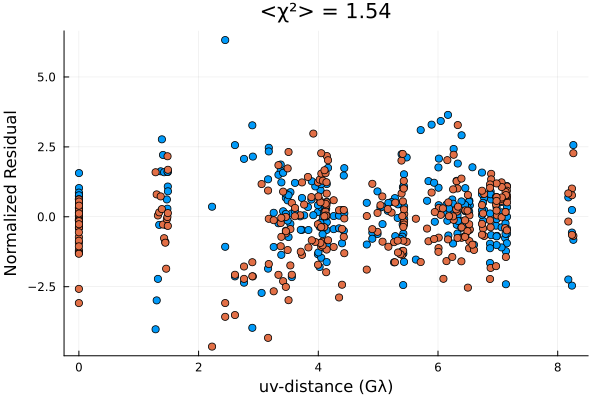

In [29]:
using Plots
residual(vlbimodel(post, xopt), dvis)

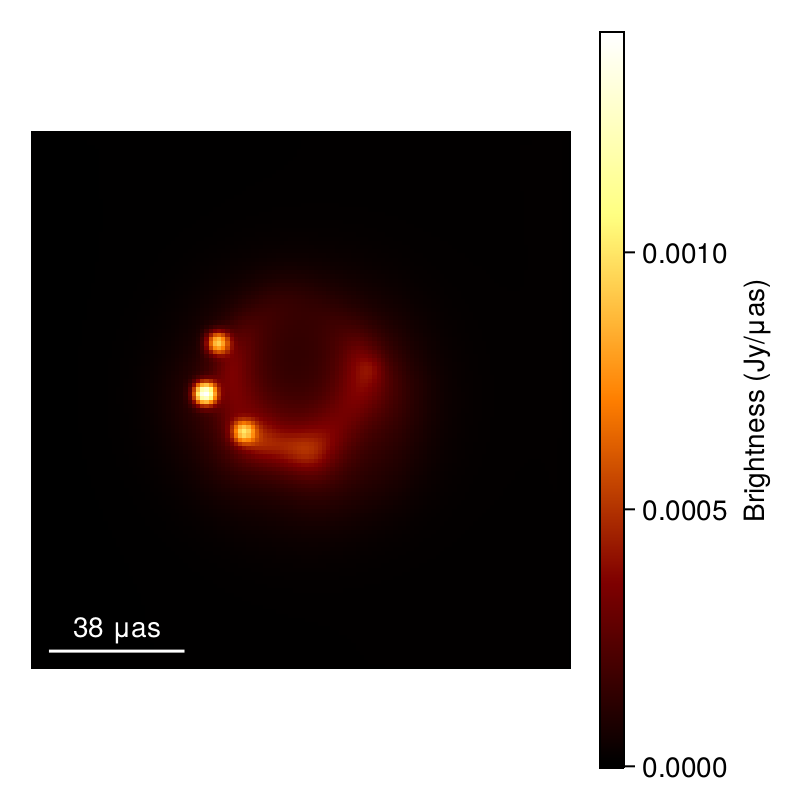

In [30]:
import CairoMakie as CM
img = intensitymap(skymodel(post, xopt), fovx, fovy, 128, 128)
imageviz(img, size=(400, 400))

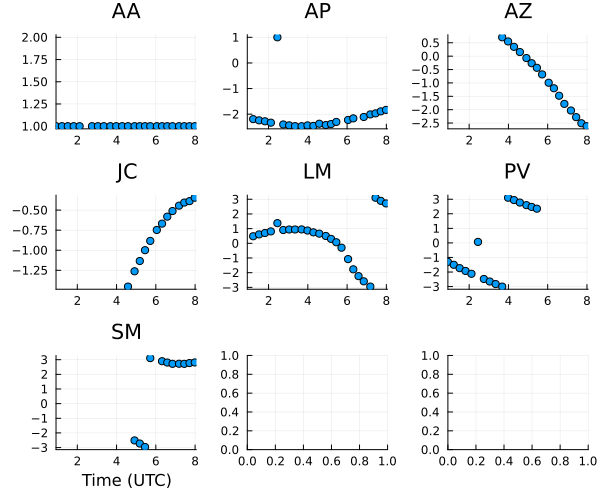

In [31]:
gt = Comrade.caltable(gcachep, xopt.gphase)
plot(gt, layout=(3,3), size=(600,500))

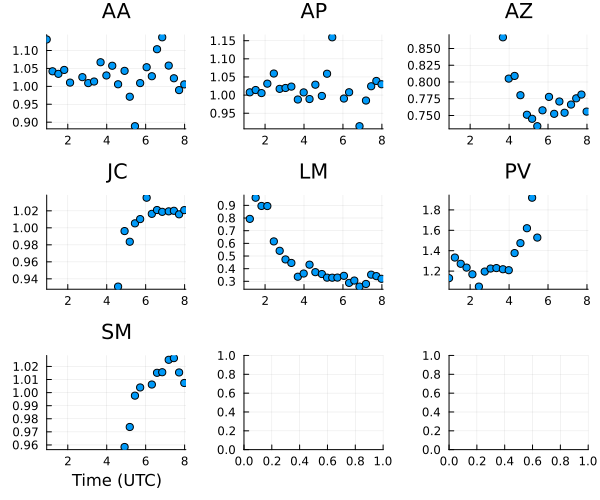

In [32]:
gt = Comrade.caltable(gcache, exp.(xopt.lgamp))
plot(gt, layout=(3,3), size=(600,500))

In [33]:
using ComradeAHMC
metric = DiagEuclideanMetric(ndim)
chain, stats = sample(rng, post, 
    AHMC(;metric, autodiff=Val(:Zygote)), 
    700; 
    n_adapts=500, initial_params=xopt, progress=false)

(NamedTuple{(:c, :fg, :σimg, :lgamp, :gphase), Tuple{NamedTuple{(:params, :hyperparams), Tuple{Matrix{Float64}, Float64}}, Float64, Float64, Vector{Float64}, Vector{Float64}}}[(c = (params = [-0.008411673581879877 -0.07980601992761147 … 0.0022571881637325646 -0.11099109328812101; -0.09206740657670691 -0.02136093504153507 … -0.04550149751356247 0.04587439293006133; … ; -0.010247115110168549 0.07169049378606301 … -0.07555783443597469 0.11082803417100409; -0.12732686886557218 -0.03381126522567321 … -0.05272521537785587 0.03186271672157185], hyperparams = 0.10339816670413753), fg = 0.17391119111426653, σimg = 3.3115732295016396, lgamp = [0.17842203300560272, 0.049584893171399316, 0.025967424496775138, 0.019347524118240627, -0.2150081065186603, 0.2690230230117454, 0.027160689995729324, 0.031148632860910193, -0.0602148073749958, 0.2427232465496625  …  -0.2601080175890346, 0.00253386469990199, -1.0644664115533056, 0.03393402724904399, 0.0017982130251949764, 0.0250871666933543, -0.282476823800

In [34]:
chain = chain[501:end]

Table with 5 columns and 200 rows:
      c                     fg        σimg      lgamp                 ⋯
    ┌──────────────────────────────────────────────────────────────────
 1  │ (params = [0.550187…  0.366415  0.938119  [-0.0182498, 0.0131…  ⋯
 2  │ (params = [1.05617 …  0.366093  1.04122   [-0.00451788, -0.01…  ⋯
 3  │ (params = [0.58669 …  0.367     1.06702   [0.00390414, -0.002…  ⋯
 4  │ (params = [2.27735 …  0.36506   1.04657   [0.0127018, 0.02396…  ⋯
 5  │ (params = [1.22311 …  0.385966  1.05369   [0.179965, -0.19028…  ⋯
 6  │ (params = [1.57495 …  0.380571  0.943325  [-0.0808612, 0.0462…  ⋯
 7  │ (params = [1.19569 …  0.360944  0.977825  [-0.0588704, 0.0309…  ⋯
 8  │ (params = [1.22611 …  0.368743  0.966177  [-0.0356078, -0.009…  ⋯
 9  │ (params = [1.53264 …  0.363666  0.981726  [-0.039969, 0.01054…  ⋯
 10 │ (params = [-0.11202…  0.339318  1.00496   [0.0564597, -0.1001…  ⋯
 11 │ (params = [-0.91221…  0.342742  0.984726  [-0.0968902, 0.0492…  ⋯
 12 │ (params = [0.889505…  0

In [35]:
gphase  = hcat(chain.gphase...)
mgphase = mean(gphase, dims=2)
sgphase = std(gphase, dims=2)

101×1 Matrix{Float64}:
 0.33774470809370805
 0.018043132971053692
 0.12568591753150118
 0.7654185300420615
 0.014160416124261128
 0.12188212886921
 2.3417077632057577
 0.019984739430710222
 0.1251410531750631
 2.769504108028307
 0.020270814168957662
 0.12374761156208461
 2.8220038404074574
 ⋮
 1.3218200448681183
 0.25674698659857914
 0.016708676872597555
 0.12905197922184788
 0.2548756087923705
 2.9749276690680313
 0.25505389204449863
 0.0181468992221285
 0.13268881608778105
 0.25364328116266205
 0.9512635285198399
 0.2528349742164944

In [36]:
gamp  = exp.(hcat(chain.lgamp...))
mgamp = mean(gamp, dims=2)
sgamp = std(gamp, dims=2)

126×1 Matrix{Float64}:
 0.06886630413065846
 0.06871693851584118
 0.021947695739511615
 0.022907404421799324
 0.03928416033989059
 0.039493022305560864
 0.020145275982752623
 0.021632923699697524
 0.04281158396712667
 0.041306807101342206
 0.017854184185797085
 0.02115325373361343
 0.040092380390554905
 ⋮
 0.013576517405404586
 0.021624728573875884
 0.02864189886876037
 0.01762448742943042
 0.017578271918276756
 0.0159972322891455
 0.014788192906966343
 0.02015171174459125
 0.030020775182742307
 0.016518311230815427
 0.01737122393418991
 0.018966459758781834

In [37]:
using Measurements
gmeas_am = measurement.(mgamp, sgamp)

# caltable expects gmeas_am to be a Vector
ctable_am = caltable(gcache, vec(gmeas_am)) 
gmeas_ph = measurement.(mgphase, sgphase)
ctable_ph = caltable(gcachep, vec(gmeas_ph))

┌ Info: Precompiling Measurements [eff96d63-e80a-5855-80a2-b1b0885c5ab7]
└ @ Base loading.jl:1664


───────────┬────────────────────────────────────────────────────────────────────
      time │      AA            AP           AZ          JC           LM       ⋯
───────────┼────────────────────────────────────────────────────────────────────
 0.917±0.0 │ 1.0±0.0       missing      missing     missing      missing  -2.4 ⋯
 1.217±0.0 │ 1.0±0.0  -2.192±0.018      missing     missing    0.84±0.13  -2.4 ⋯
 1.517±0.0 │ 1.0±0.0  -2.241±0.014      missing     missing    0.92±0.12    -1 ⋯
 1.817±0.0 │ 1.0±0.0   -2.274±0.02      missing     missing    0.97±0.12   -0. ⋯
 2.117±0.0 │ 1.0±0.0   -2.326±0.02      missing     missing    1.04±0.12    0. ⋯
  2.45±0.0 │ missing       1.0±0.0      missing     missing    1.57±0.13   -1. ⋯
  2.75±0.0 │ 1.0±0.0  -2.402±0.019      missing     missing    1.08±0.12     1 ⋯
  3.05±0.0 │ 1.0±0.0  -2.436±0.016      missing     missing    1.11±0.12     2 ⋯
  3.35±0.0 │ 1.0±0.0  -2.466±0.016      missing     missing     1.1±0.12   2.3 ⋯
 3.683±0.0 │ 1.0±0.0  -2.468

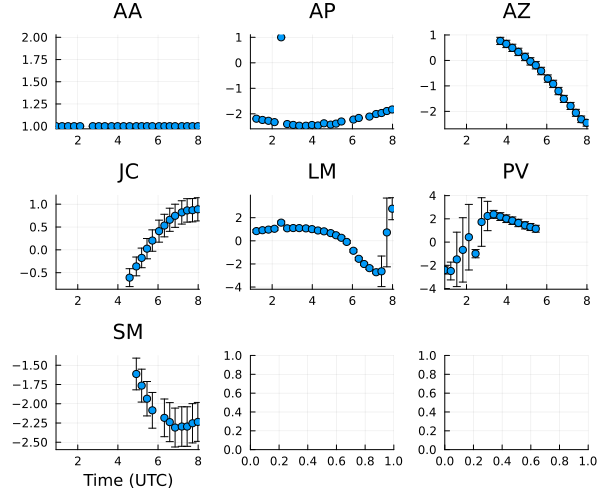

In [38]:
plot(ctable_ph, layout=(3,3), size=(600,500))

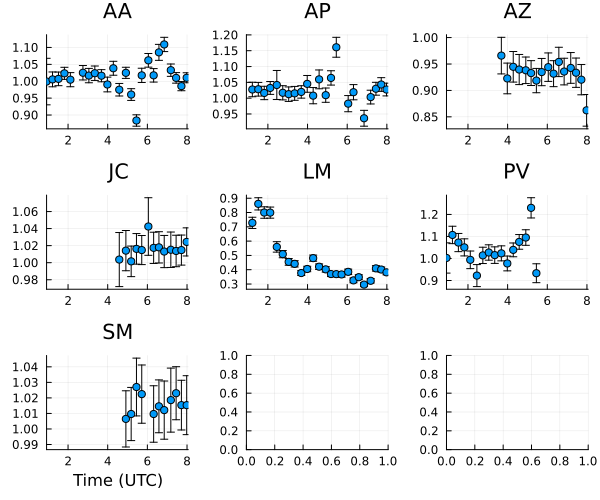

In [39]:
plot(ctable_am, layout=(3,3), size=(600,500))

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/bread/.julia/packages/Makie/z2T2o/src/scenes.jl:220


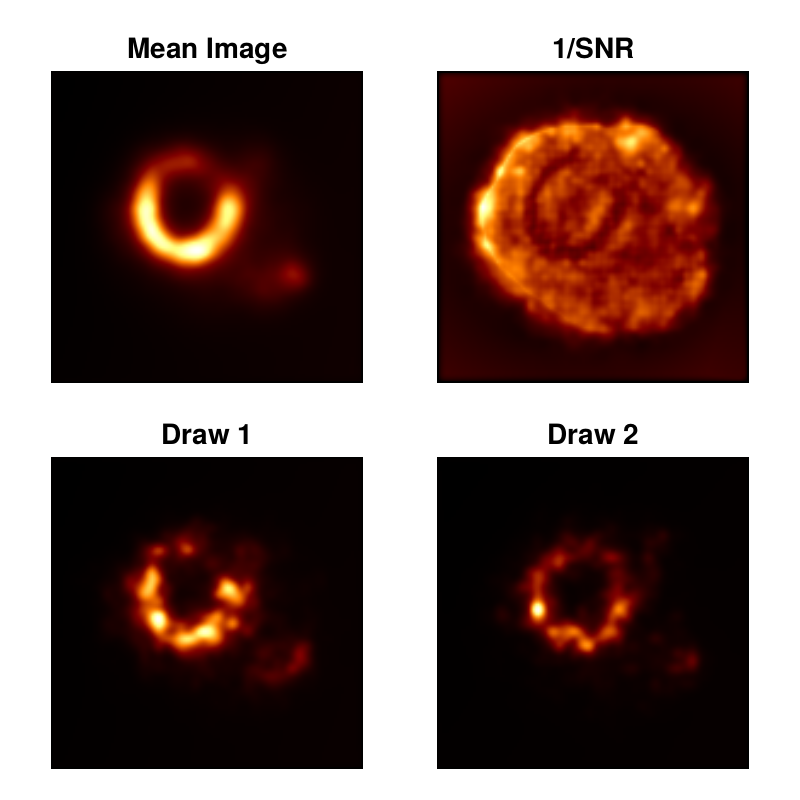

In [40]:
samples = skymodel.(Ref(post), chain[begin:2:end])
imgs = intensitymap.(samples, fovx, fovy, 128,  128)

mimg = mean(imgs)
simg = std(imgs)
fig = CM.Figure(;resolution=(400, 400))
CM.image(fig[1,1], mimg,
                   axis=(xreversed=true, aspect=1, title="Mean Image"),
                   colormap=:afmhot)
CM.image(fig[1,2], simg./(max.(mimg, 1e-5)),
                   axis=(xreversed=true, aspect=1, title="1/SNR",),
                   colormap=:afmhot)
CM.image(fig[2,1], imgs[1],
                   axis=(xreversed=true, aspect=1,title="Draw 1"),
                   colormap=:afmhot)
CM.image(fig[2,2], imgs[end],
                   axis=(xreversed=true, aspect=1,title="Draw 2"),
                   colormap=:afmhot)
CM.hidedecorations!.(fig.content)
fig